In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Scripts/.' .

In [0]:
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/train_images320x480.zip'
!unzip -q '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/Data/test_images320x480.zip'

### Dependencies

In [4]:
from utillity_script_cloud_segmentation import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

In [0]:
base_path = '/content/drive/My Drive/Colab Notebooks/[Kaggle] Understanding Clouds from Satellite Images/'
data_path = base_path + 'Data/'
classification_model_base_path = base_path + 'Models/files/classification/'
classification_model_path = classification_model_base_path + '19-EfficientNetB0_224x224_Cyclical_triangular.h5'
segmentation_model_base_path = base_path + 'Models/files/segmentation/'
segmentation_model_path_list = [segmentation_model_base_path + '57-unet[fold-1]_efficientnetb3_320x480.h5', 
                                segmentation_model_base_path + '57-unet[fold-2]_efficientnetb3_320x480.h5', 
                                segmentation_model_base_path + '57-unet[fold-3]_efficientnetb3_320x480.h5', 
                                segmentation_model_base_path + '57-unet[5fold-1]_efficientnetb3_320x480.h5', 
                                segmentation_model_base_path + '57-unet[5fold-2]_efficientnetb3_320x480.h5', 
                                segmentation_model_base_path + '57-unet[5fold-3]_efficientnetb3_320x480.h5']

submission_base_path = data_path + 'submissions/inference/'
train_path = data_path + 'train.csv'
hold_out_path = data_path + 'hold-out.csv'
test_path = data_path + 'sample_submission.csv'
train_images_path = 'train_images/'
test_images_path = 'test_images/'

### Load data

In [7]:
train = pd.read_csv(train_path)
hold_out_set = pd.read_csv(hold_out_path)
submission = pd.read_csv(test_path)

X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))
print('Test samples:', len(submission))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(submission.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105
Test samples: 14792


,Image_Label,EncodedPixels,image
0,002f507.jpg_Fish,1 1,002f507.jpg
1,002f507.jpg_Flower,1 1,002f507.jpg
2,002f507.jpg_Gravel,1 1,002f507.jpg
3,002f507.jpg_Sugar,1 1,002f507.jpg
4,0035ae9.jpg_Fish,1 1,0035ae9.jpg


# Model parameters

In [0]:
BACKBONE = 'efficientnetb3'
CLASS_HEIGHT = 224
CLASS_WIDTH = 224
SEG_HEIGHT = 320
SEG_WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
TTA_STEPS = 8
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
best_tresholds_class = [0.64, 0.52, 0.61, 0.59] # beta 0.5

model_name = '57-[seg]57-unet[53-Fold]_efficientnetb3_320x480[class]19-EfficientNetB0'
submission_post_tta_path = submission_base_path + '%s_submission_post_tta.csv' % (model_name)
submission_post_tta_class_path = submission_base_path + '%s_submission_post_class_tta.csv' % (model_name)

In [0]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [10]:
classification_model = load_model(classification_model_path)
segmentation_model_list = []
for model_path in segmentation_model_path_list:
    segmentation_model_list.append(load_model(model_path, custom_objects={'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score}))

segmentation_model = ensemble_models((SEG_HEIGHT, SEG_WIDTH, CHANNELS), segmentation_model_list, rename_model=True)
segmentation_model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
ensemble_0_model_14 (Model)     (None, 320, 480, 4)  17868268    input_1[0][0]                    
__________________________________________________________________________________________________
ensemble_1_model_2 (Model)      (None, 320, 480, 4)  17868268    input_1[0][0]                    
________________________________________________________________

## Segmentation threshold and mask size tunning

In [11]:
mask_grid = [0, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500]
threshold_grid = np.arange(.3, 1, .05)
best_tresholds_seg, best_masks_seg = segmentation_tunning(segmentation_model, train, X_val, train_images_path, (SEG_HEIGHT, SEG_WIDTH), label_columns, mask_grid, threshold_grid, N_CLASSES, preprocessing, seed, batch_size=300)

Fish treshold=0.45 mask size=12500 Dice=0.683
Flower treshold=0.45 mask size=17500 Dice=0.805
Gravel treshold=0.55 mask size=20000 Dice=0.659
Sugar treshold=0.55 mask size=10000 Dice=0.626


## Model evaluation

In [12]:
train_metrics = get_metrics(segmentation_model, train, X_train, train_images_path, (SEG_HEIGHT, SEG_WIDTH), label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, set_name='Train', batch_size=300)
display(train_metrics)

validation_metrics = get_metrics(segmentation_model, train, X_val, train_images_path, (SEG_HEIGHT, SEG_WIDTH), label_columns, best_tresholds_seg, best_masks_seg, seed=seed, preprocessing=preprocessing, set_name='Validation', batch_size=300)
display(validation_metrics)

,Dice,Dice Post
Class,,
Fish,0.613313,0.673707
Flower,0.756836,0.795151
Gravel,0.569905,0.646896
Sugar,0.578209,0.627689
Train,0.629566,0.685861


,Dice,Dice Post
Class,,
Fish,0.624279,0.683306
Flower,0.759344,0.804981
Gravel,0.585686,0.658751
Sugar,0.575860,0.626202
Validation,0.636292,0.693310


# Inspecting some of the validation set predictions
## Without post-process

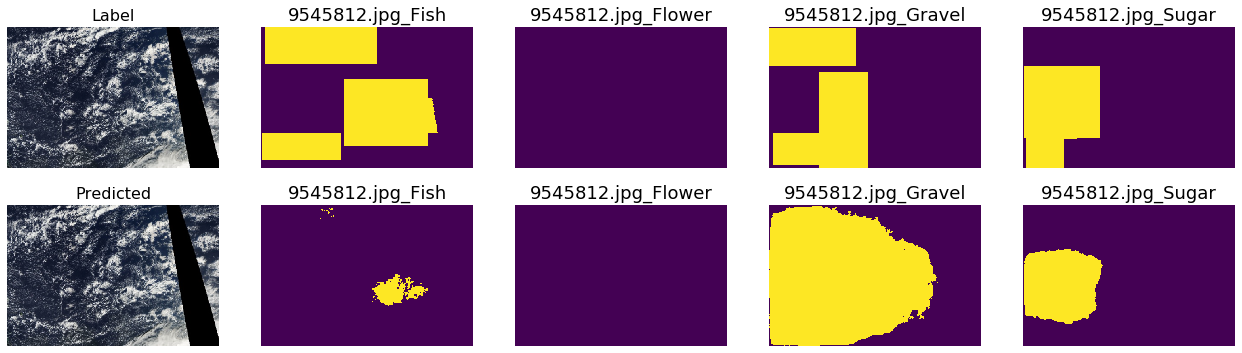

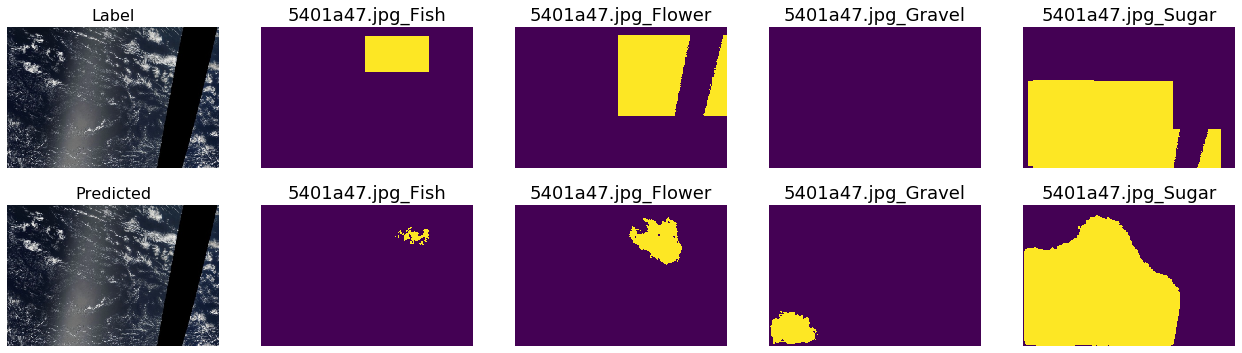

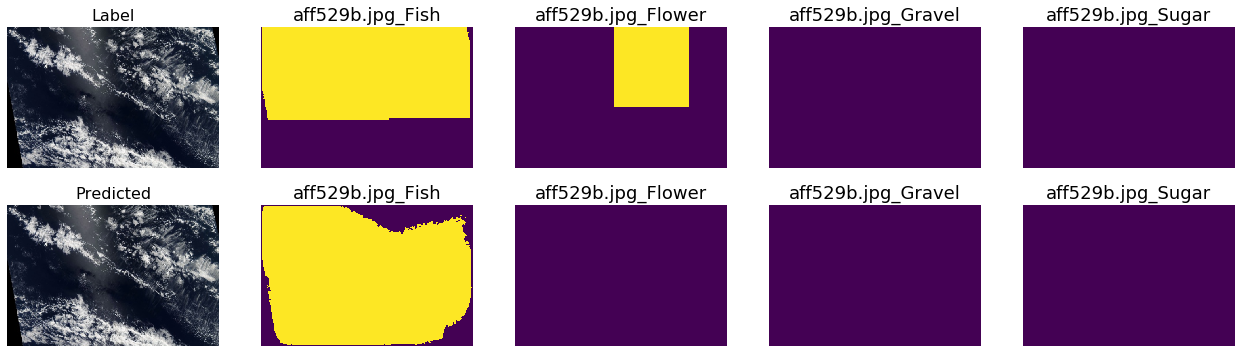

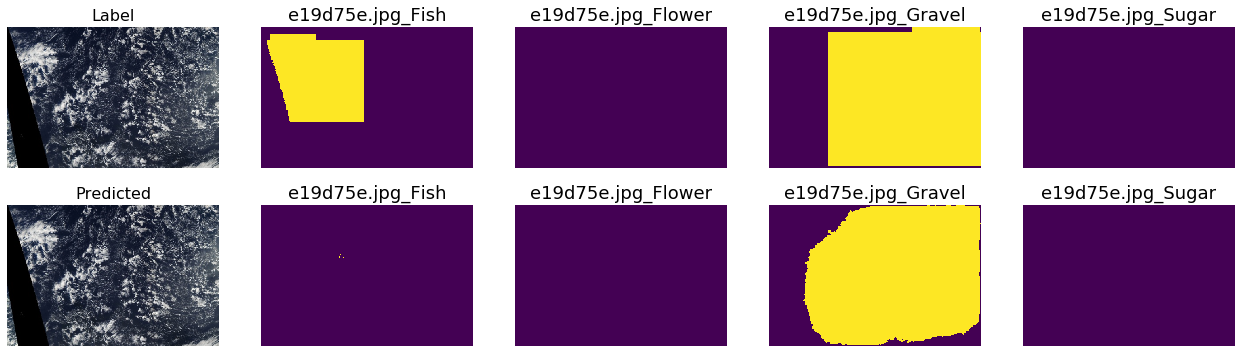

In [13]:
images_to_inspect = np.random.choice(X_val['image'].unique(), 4, replace=False)
inspect_set = train[train['image'].isin(images_to_inspect)].copy()
inspect_set_class = X_val[X_val['image'].isin(images_to_inspect)].copy()
inspect_set_temp = []

inspect_generator = DataGenerator(
                    directory=train_images_path,
                    dataframe=inspect_set,
                    target_df=train,
                    batch_size=1, 
                    target_size=(SEG_HEIGHT, SEG_WIDTH),
                    n_channels=CHANNELS,
                    n_classes=N_CLASSES,
                    preprocessing=preprocessing,
                    seed=seed,
                    mode='fit',
                    shuffle=False)

preds = segmentation_model.predict_generator(inspect_generator)

for index, b in enumerate(range(len(preds))):
    filename = inspect_set['image'].iloc[b]
    image_df = inspect_set[inspect_set['image'] == filename].copy()
    pred_masks = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks[..., class_index]
        pred_mask = post_process(pred_mask, threshold=.5, min_size=0)
        pred_masks[...,class_index] = pred_mask

    pred_rles = build_rles(pred_masks, reshape=(350, 525))
    image_df['EncodedPixels_pred'] = pred_rles
    
    ### Post procecssing
    pred_masks_post = preds[index, ].astype('float32') 
    for class_index in range(N_CLASSES):
        pred_mask = pred_masks_post[..., class_index]
        pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
        pred_masks_post[...,class_index] = pred_mask

    pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
    image_df['EncodedPixels_pred_post'] = pred_rles_post
    
    inspect_set_temp.append(image_df)

inspect_set = pd.concat(inspect_set_temp)
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred')

### With post-process

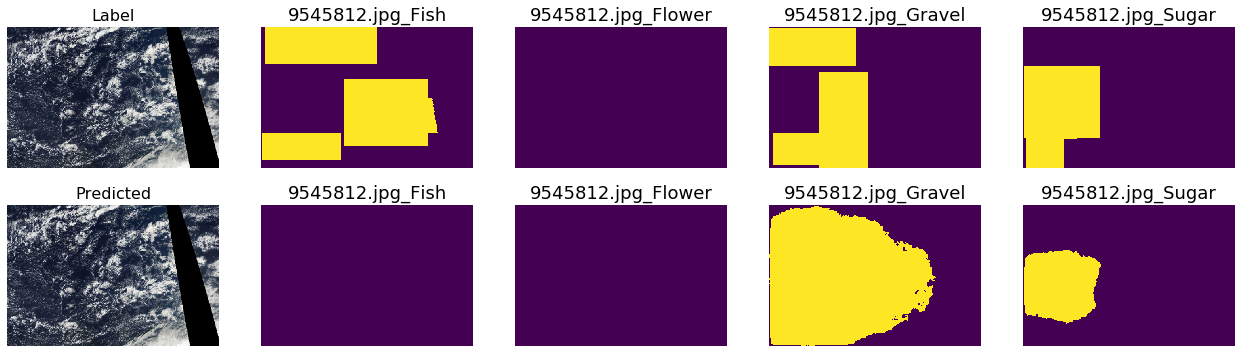

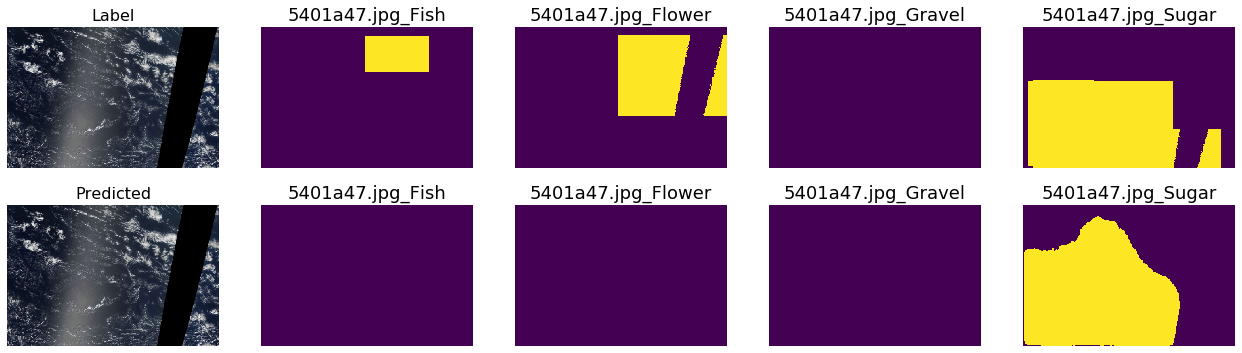

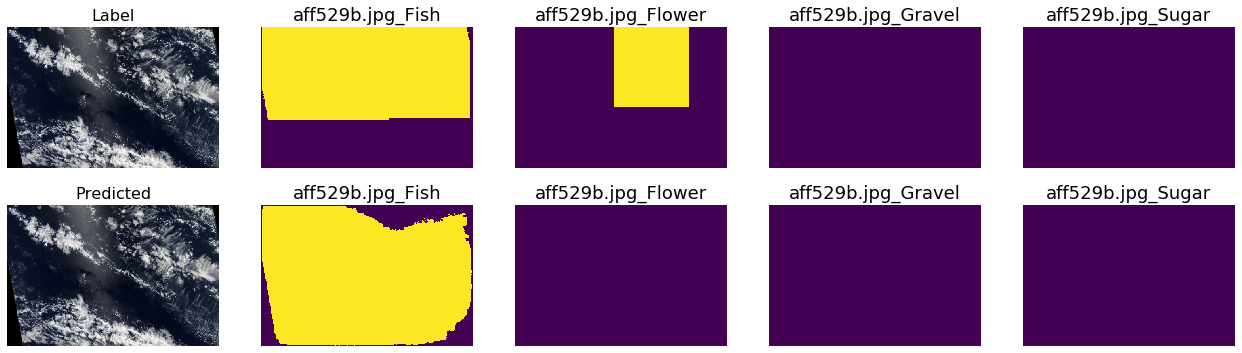

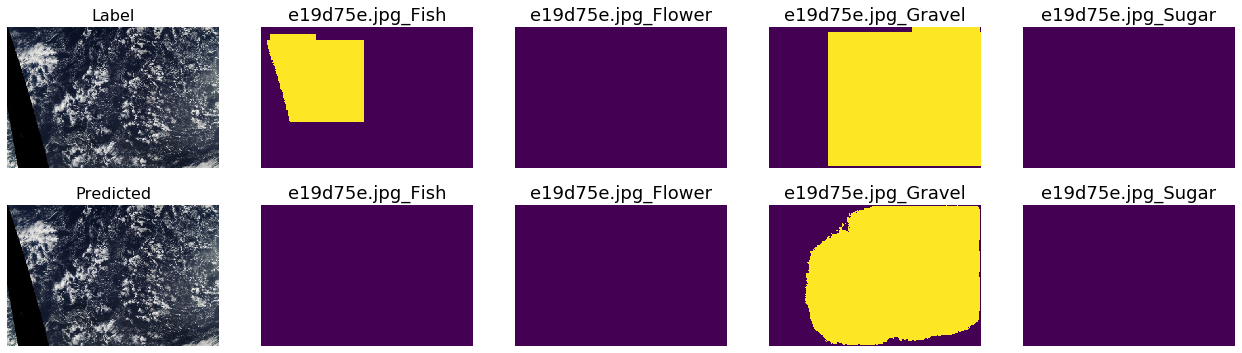

In [14]:
inspect_predictions(inspect_set, images_to_inspect, train_images_path, pred_col='EncodedPixels_pred_post')

### Classification data generator

In [15]:
test_datagen=ImageDataGenerator(rescale=1./255.,
                                vertical_flip=True,
                                horizontal_flip=True,
                                zoom_range=[1, 1.2],
                                fill_mode='constant',
                                cval=0.)

classification_test_generator=test_datagen.flow_from_dataframe(
                                            dataframe=test,
                                            directory=test_images_path,
                                            x_col="image",
                                            target_size=(CLASS_HEIGHT, CLASS_WIDTH),
                                            class_mode=None,
                                            batch_size=1,
                                            shuffle=False,
                                            seed=seed)

Found 3698 validated image filenames.


# Using TTA Wrapper

In [16]:
segmentation_model_tta = tta_segmentation(segmentation_model, h_flip=True, v_flip=True, rotation=(180), merge='mean')
segmentation_model_tta.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (1, 320, 480, 3)          0         
_________________________________________________________________
repeat_1 (Repeat)            (8, 320, 480, 3)          0         
_________________________________________________________________
tta_1 (TTA)                  (8, 320, 480, 3)          0         
_________________________________________________________________
model_1 (Model)              multiple                  107209608 
_________________________________________________________________
tta_2 (TTA)                  (24, 320, 480, 4)         0         
_________________________________________________________________
merge_1 (Merge)              (1, 320, 480, 4)          0         
Total params: 107,209,608
Trainable params: 106,673,928
Non-trainable params: 535,680
______________________________________

# Apply segmentation model to test set (TTA)

In [0]:
#@title
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(SEG_HEIGHT, SEG_WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = segmentation_model_tta.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks[..., class_index]
            pred_mask = post_process(pred_mask, threshold=.5, min_size=15000)
            pred_masks[...,class_index] = pred_mask

        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels_tta'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32')
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds_seg[class_index], min_size=best_masks_seg[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post_tta'] = pred_rles_post
        
        test_df.append(image_df)

X_test_tta = pd.concat(test_df)

# Apply classifcation model to test set

In [0]:
test_class_preds = apply_tta(classification_model, classification_test_generator, steps=TTA_STEPS)

for index in range(len(label_columns)):
  test_class_preds[:,index] = (test_class_preds[:,index] > best_tresholds_class[index]).astype(int)

X_test_tta['empty_mask'] = test_class_preds.reshape(test_class_preds.shape[0]*N_CLASSES)
X_test_tta['EncodedPixels_post_tta_class'] = X_test_tta.apply(lambda row: row['EncodedPixels_post_tta'] if row['empty_mask'] == 0 else '', axis=1)

### Number of masks removed

In [19]:
print('Using TTA wrapper')
print('Masks removed in "%s": %s' % ('EncodedPixels_post_tta_class', len(X_test_tta[(X_test_tta['EncodedPixels_post_tta'] != '') & (X_test_tta['empty_mask'] == 1)])))

Using TTA wrapper
Masks removed in "EncodedPixels_post_tta_class": 305


## Inspecting some of the test set predictions

### Without post-process and TTA

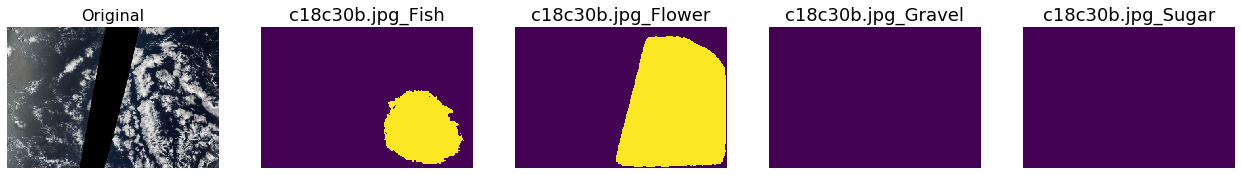

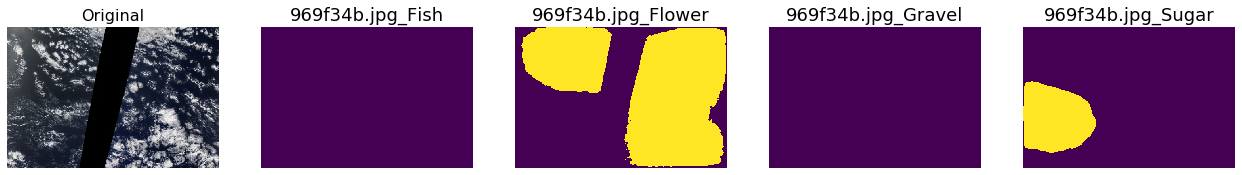

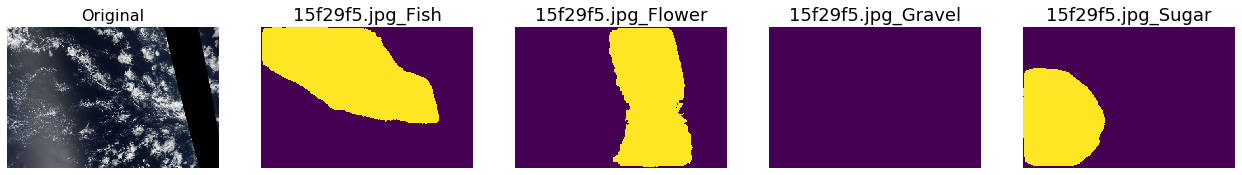

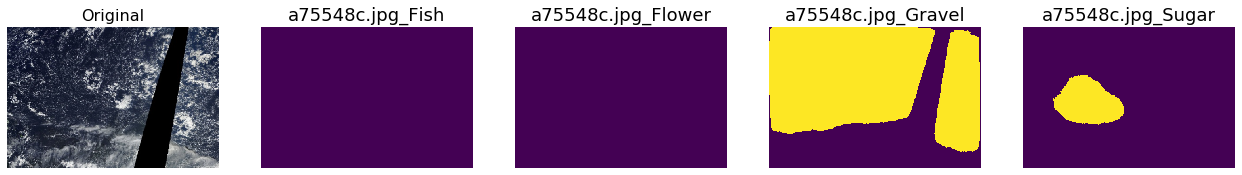

In [21]:
images_to_inspect_test =  np.random.choice(X_test_tta['image'].unique(), 4, replace=False)
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_tta')

### With post-process and TTA

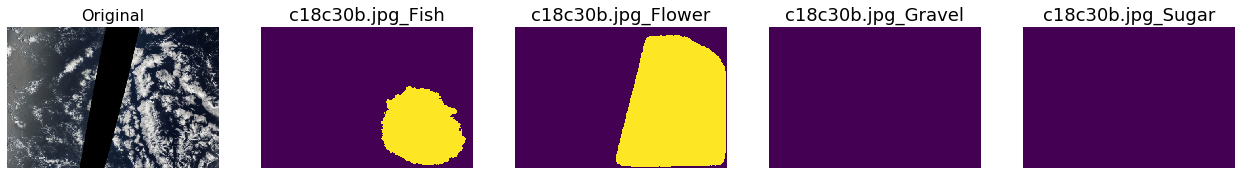

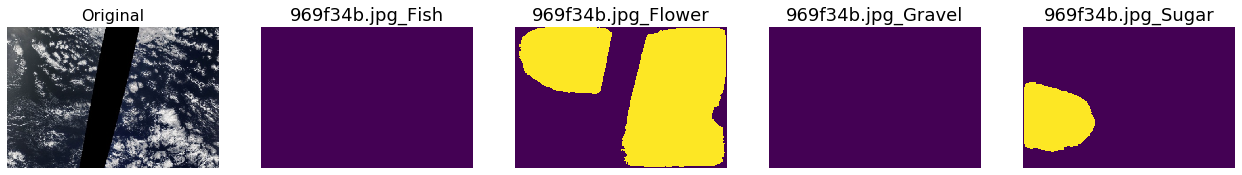

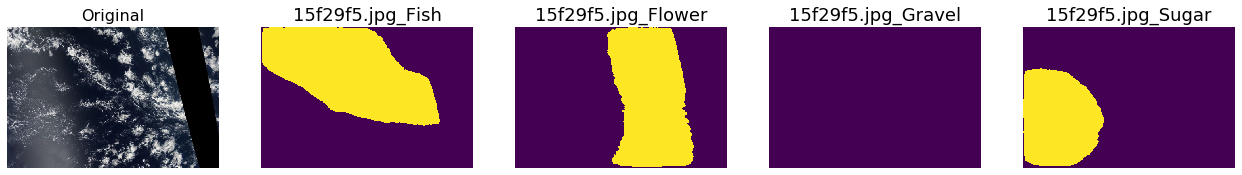

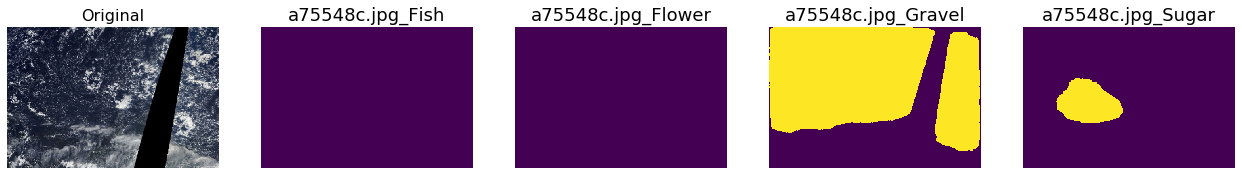

In [22]:
inspect_predictions(X_test_tta, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_tta')

### Submission with post processing and TTA

In [23]:
submission_df = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_tta_path, index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,61 97 162 53 217 4 225 1 411 97 512 53 567 4 5...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


### Submission with post processing, mask classification and TTA (beta 0.5)

In [24]:
submission_df = X_test_tta[['Image_Label' ,'EncodedPixels_post_tta_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv(submission_post_tta_class_path, index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,61 97 162 53 217 4 225 1 411 97 512 53 567 4 5...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,
